# Multivariate analysis

Interpret all of the plate kinematic and rheological information within a statistical framework.

In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sn
import gplately
%matplotlib inline

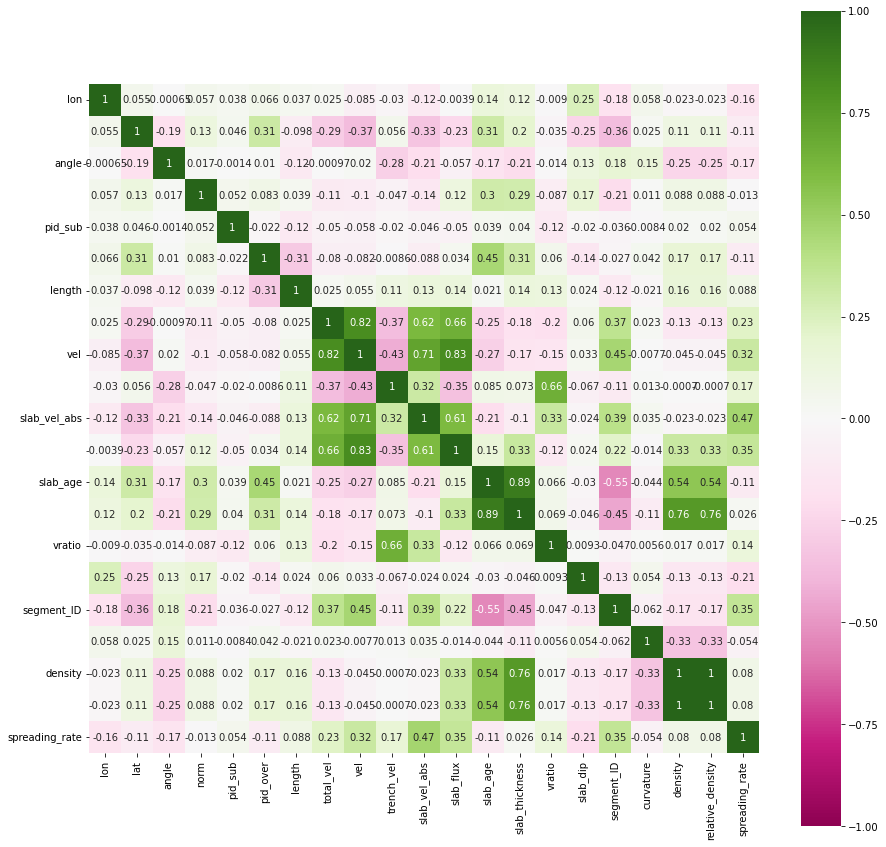

In [2]:
df = pd.read_csv("data/subduction_data.csv", index_col=0)

# remove ultra slow convergence velocities
# df = df[df['vel'] > 0.01]

# remove NaN entries
df = df[np.isfinite(df['slab_dip'])]

# remove europe
# df = df[np.logical_or(df['lon'] > 70, df['lon'] < -20)]

# Plot a Pearson correlation coefficient matrix
sn.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='PiYG', square=True)
fig = plt.gcf()
fig.set_size_inches(15, 15)

In [3]:
df.columns

Index(['lon', 'lat', 'angle', 'norm', 'pid_sub', 'pid_over', 'length',
       'total_vel', 'vel', 'trench_vel', 'slab_vel_abs', 'slab_flux',
       'slab_age', 'slab_thickness', 'vratio', 'slab_dip', 'segment_ID',
       'curvature', 'density', 'relative_density', 'spreading_rate'],
      dtype='object')

In [4]:
df_stats = df.describe()
df_stats

,lon,lat,angle,norm,pid_sub,pid_over,length,total_vel,vel,trench_vel,...,slab_flux,slab_age,slab_thickness,vratio,slab_dip,segment_ID,curvature,density,relative_density,spreading_rate
count,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,...,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000,1130.000000
mean,26.513316,9.557946,0.621437,168.240638,1290.280531,77832.769912,42205.628815,0.057107,0.050428,-0.010151,...,3512.602722,72.255141,72629.339973,0.788405,35.122807,26.053097,0.000015,3282.444222,-17.555778,0.039740
std,118.466534,28.620140,39.052331,120.727691,12639.826511,160984.759423,11299.777943,0.043068,0.032284,0.024077,...,2630.354925,56.213458,27135.798264,0.271681,12.738036,14.859687,0.000244,58.134206,58.134206,0.025835
min,-179.937538,-60.675510,-167.067827,1.451468,101.000000,101.000000,774.618467,-0.134422,0.000000,-0.104441,...,0.000000,0.000000,0.000000,0.000000,1.061921,0.000000,-0.000655,2900.000000,-400.000000,0.000590
25%,-79.468352,-9.467675,-22.315619,54.637442,674.000000,645.000000,35912.523102,0.032455,0.021181,-0.019674,...,1189.563549,25.344196,51860.094070,0.681773,27.848783,12.000000,-0.000033,3273.375728,-26.624272,0.020264
50%,34.005493,6.829991,0.905115,130.527140,838.000000,736.000000,45335.757018,0.062861,0.052038,-0.007488,...,3166.032322,53.819028,75416.803360,0.906602,35.973342,25.000000,-0.000002,3301.232936,1.232936,0.037076
75%,137.512715,35.776461,21.602225,291.396023,901.000000,12001.000000,50503.323104,0.088453,0.073047,0.005169,...,5472.525506,116.821843,99084.019661,1.000000,43.517157,39.000000,0.000036,3312.805448,12.805448,0.056310
max,179.426407,60.451013,168.336842,359.685144,301300.000000,714004.000000,55597.541862,0.168125,0.145023,0.054192,...,12253.404369,216.165560,105298.280716,1.000000,71.382011,48.000000,0.003373,3314.500778,14.500778,0.167724


## Regression and machine learning

We use the regression and machine learning routines in [scikit-learn](https://scikit-learn.org) (`sklearn`) to infer slab dip from plate kinematics and rheology. To do this, we train the model (linear model, neural network, etc.) on a matrix $X_{t=0}$, which contains our training data, to predict our result $y_{t=0}$, which is the slab dip for the present day.

Depending on how well the model can reproduce the slab dip at the present day, we can apply the same model to predict the slab dip back through geological time by feeding the input variables reconstructed to different geological times $X_{t=1,2,\ldots,k}$.

First, we subset the data for variables which show promise of predicting slab dip. These can be added or removed to improve the predction.

In [5]:
df_stats.keys()

Index(['lon', 'lat', 'angle', 'norm', 'pid_sub', 'pid_over', 'length',
       'total_vel', 'vel', 'trench_vel', 'slab_vel_abs', 'slab_flux',
       'slab_age', 'slab_thickness', 'vratio', 'slab_dip', 'segment_ID',
       'curvature', 'density', 'relative_density', 'spreading_rate'],
      dtype='object')

In [6]:
variable_names = ['angle', 'total_vel', 'vel', 'trench_vel', 'vratio', 'slab_thickness', 'slab_age',
                  'spreading_rate', 'density']

df_X_train = df[variable_names]
df_y_train = df['slab_dip']

In [7]:
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.model_selection import cross_val_score, validation_curve

In [8]:
fs = feature_selection.SelectKBest(feature_selection.f_regression, k='all')
transform = fs.fit_transform(df_X_train, df_y_train)

(0.0, 49.79411788554346)

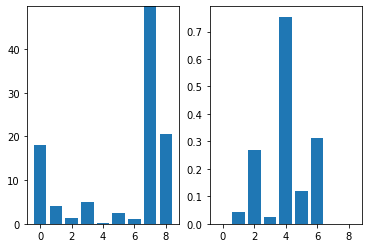

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(range(fs.n_features_in_), fs.scores_)
ax2.bar(range(fs.n_features_in_), fs.pvalues_)

ax1.set_ylim(0, max(fs.scores_))

### Linear regression

R2 value = 0.09
MSE = 9.74e-01 +/- 8.76e-01


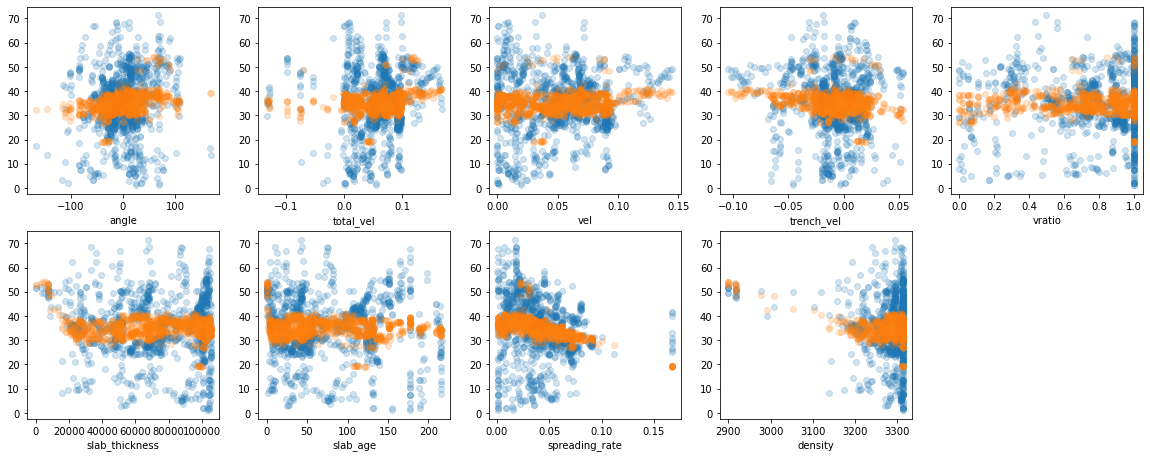

In [10]:
# rescale the input vector
scaler = preprocessing.StandardScaler()
scaler.fit(df_X_train)
X_train = scaler.transform(df_X_train)
y_train = df_y_train.values

# fit the model to the data
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

print("R2 value = {:.2f}".format(regr.score(X_train,y_train)))

# predict y given the same X
y_pred = regr.predict(X_train)

scores = cross_val_score(regr, X_train, y_train, cv=10)
print("MSE = {:.2e} +/- {:.2e}".format(-scores.mean(), scores.std()))


fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_pred, alpha=0.2)

R2 value = 0.09
MSE = 9.70e-01 +/- 8.72e-01


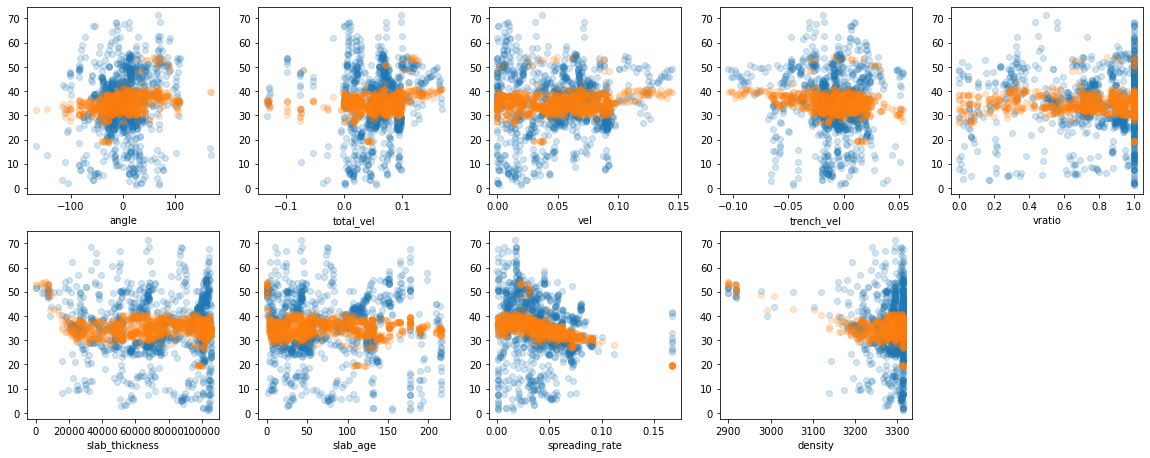

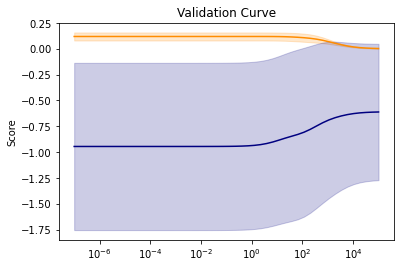

In [11]:
ridge = linear_model.Ridge()
ridge.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(ridge.score(X_train, df_y_train.values)))

scores = cross_val_score(ridge, X_train, y_train, cv=10)
print("MSE = {:.2e} +/- {:.2e}".format(-scores.mean(), scores.std()))

y_predict = ridge.predict(X_train)

fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)
    
    
param_range = np.logspace(-7,5,50)

train_scores, test_scores = validation_curve(linear_model.Ridge(), 
                                             X_train, y_train, 
                                             param_name="alpha",
                                             param_range=param_range, 
                                             cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


fig = plt.figure()
ax = fig.add_subplot(111, title='Validation Curve', ylabel='Score')
ax.semilogx(param_range, train_scores_mean, label='Training score', color='darkorange')
ax.fill_between(param_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                alpha=0.2, color='darkorange')
ax.semilogx(param_range, test_scores_mean, label='Cross-validation score', color='navy')
ax.fill_between(param_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                alpha=0.2, color='navy')

### Polynomial regression

R2 value = 0.26
MSE = 3.87e+00 +/- 4.02e+00


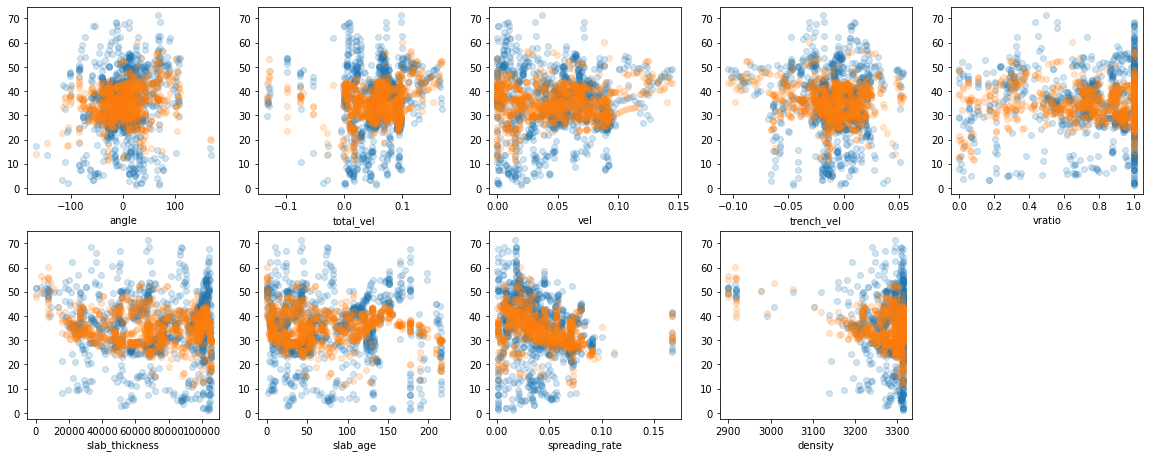

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

poly.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(poly.score(X_train, df_y_train.values)))

scores = cross_val_score(poly, X_train, y_train, cv=10)
print("MSE = {:.2e} +/- {:.2e}".format(-scores.mean(), scores.std()))

y_predict = poly.predict(X_train)


fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)


### Nearest neighbours

R2 value = 0.67
MSE = 1.06e+00 +/- 9.04e-01


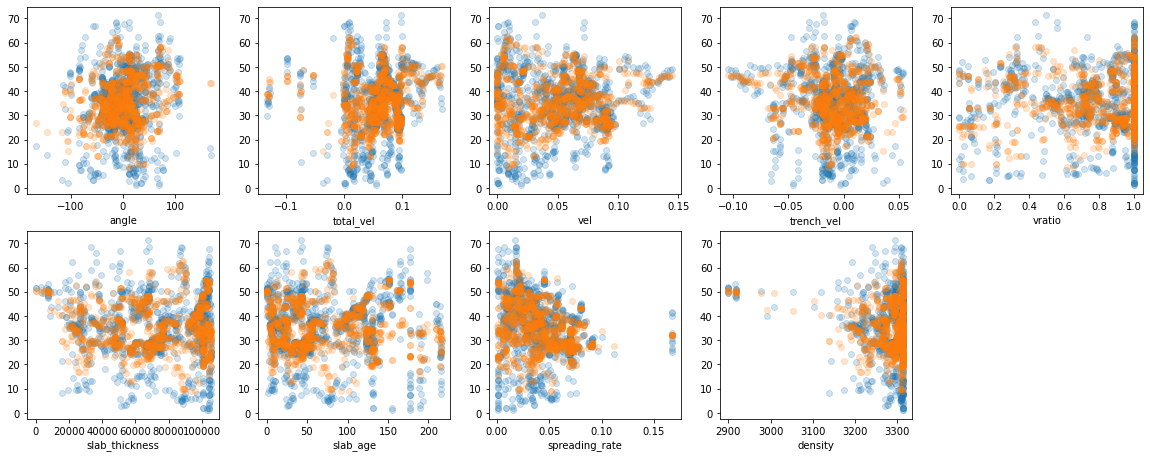

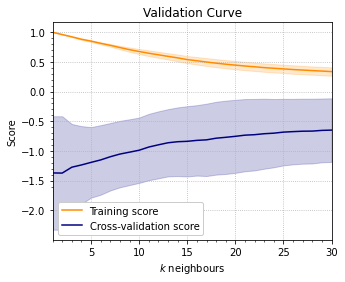

In [13]:
from sklearn.neighbors import KNeighborsRegressor

kn = KNeighborsRegressor(n_neighbors=10)
kn.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(kn.score(X_train, df_y_train.values)))

scores = cross_val_score(kn, X_train, y_train, cv=10)
print("MSE = {:.2e} +/- {:.2e}".format(-scores.mean(), scores.std()))

y_predict = kn.predict(X_train)


fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)
    
    
param_range = np.arange(1,31,1)

train_scores, test_scores = validation_curve(KNeighborsRegressor(), 
                                             X_train, y_train, 
                                             param_name="n_neighbors",
                                             param_range=param_range, 
                                             cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, title='Validation Curve', ylabel='Score', xlim=[param_range[0], param_range[-1]],
                     xlabel='$k$ neighbours')
ax.plot(param_range, train_scores_mean, label='Training score', color='darkorange')
ax.fill_between(param_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                alpha=0.2, color='darkorange')
ax.plot(param_range, test_scores_mean, label='Cross-validation score', color='navy')
ax.fill_between(param_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                alpha=0.2, color='navy')
ax.legend(framealpha=1)
ax.set_xticks(param_range, minor=True)
ax.set_yticks(np.arange(-1.6,1.1,0.1), minor=True)
ax.grid(True, linestyle=':')
fig.savefig('validation_curve.pdf', bbox_inches='tight', dpi=300)

### Gaussian Process

R2 value = 0.75
MSE = 2.94e+00 +/- 2.87e+00


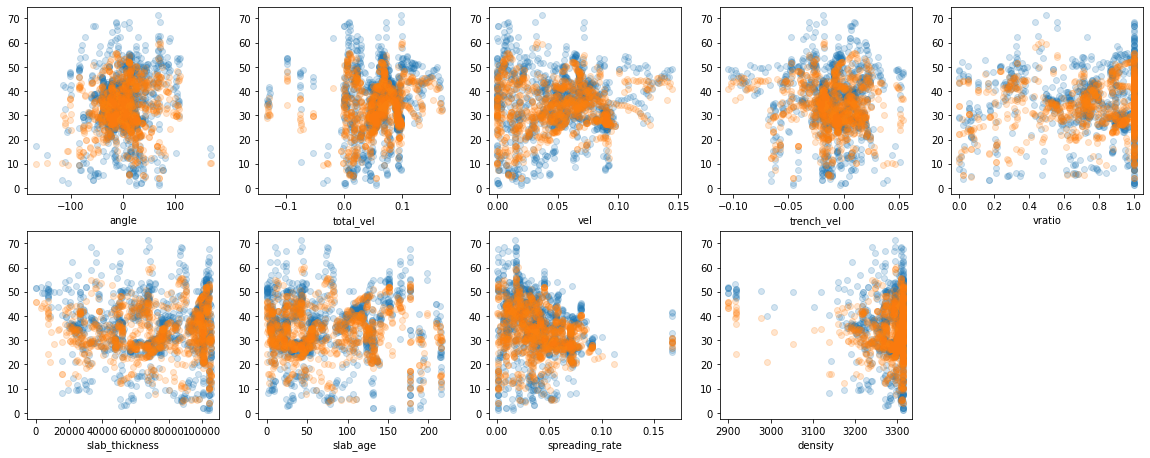

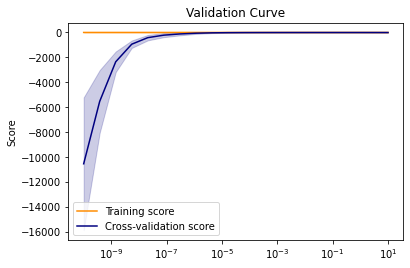

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor

gauss = GaussianProcessRegressor(alpha=1)
gauss.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(gauss.score(X_train, df_y_train.values)))

scores = cross_val_score(gauss, X_train, y_train, cv=10)
print("MSE = {:.2e} +/- {:.2e}".format(-scores.mean(), scores.std()))

y_predict = gauss.predict(X_train)


fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)


param_range = np.logspace(-10,1,20)

train_scores, test_scores = validation_curve(GaussianProcessRegressor(), 
                                             X_train, y_train, 
                                             param_name="alpha",
                                             param_range=param_range, 
                                             cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


fig = plt.figure()
ax = fig.add_subplot(111, title='Validation Curve', ylabel='Score')
ax.semilogx(param_range, train_scores_mean, label='Training score', color='darkorange')
ax.fill_between(param_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                alpha=0.2, color='darkorange')
ax.semilogx(param_range, test_scores_mean, label='Cross-validation score', color='navy')
ax.fill_between(param_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                alpha=0.2, color='navy')
ax.legend()

### Support Vector Regression (SVR)

R2 value = 0.19
MSE = 1.31e+00 +/- 1.08e+00


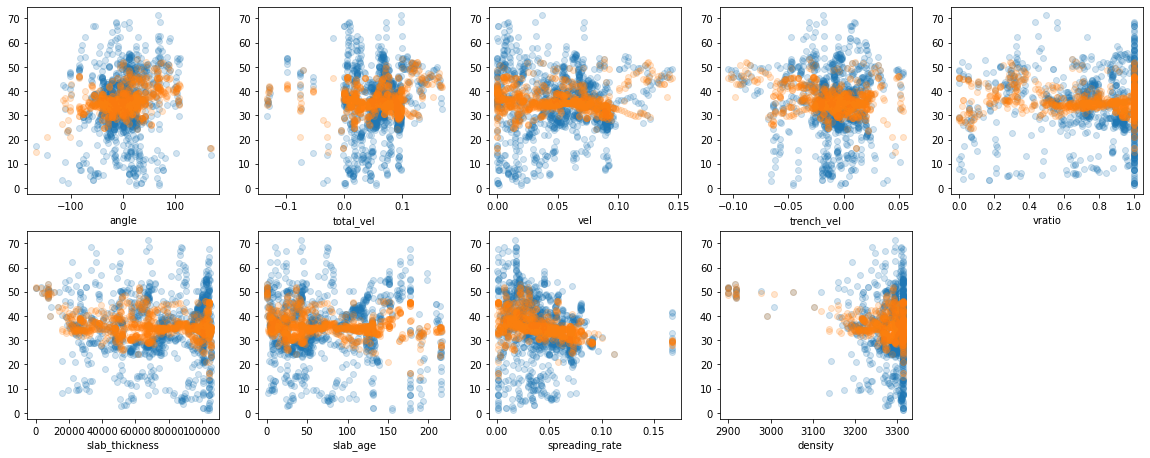

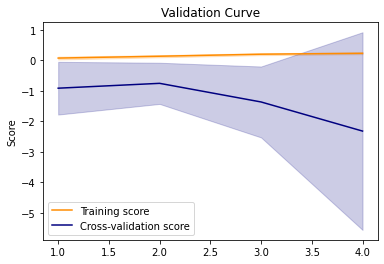

In [14]:
svr = SVR(kernel='poly', degree=3)
svr.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(svr.score(X_train, df_y_train.values)))

scores = cross_val_score(svr, X_train, y_train, cv=10)
print("MSE = {:.2e} +/- {:.2e}".format(-scores.mean(), scores.std()))

y_predict = svr.predict(X_train)


fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)
    
    
param_range = np.arange(1,5)

train_scores, test_scores = validation_curve(SVR(kernel='poly'),
                                             X_train, y_train, 
                                             param_name="degree",
                                             param_range=param_range, 
                                             cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


fig = plt.figure()
ax = fig.add_subplot(111, title='Validation Curve', ylabel='Score')
ax.plot(param_range, train_scores_mean, label='Training score', color='darkorange')
ax.fill_between(param_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                alpha=0.2, color='darkorange')
ax.plot(param_range, test_scores_mean, label='Cross-validation score', color='navy')
ax.fill_between(param_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                alpha=0.2, color='navy')
ax.legend()

### Machine learning

A multi-layer perceptron regressor (`MLPregressor`)  iteratively trains a neural network using the partial derivatives of the objective (or loss) function with respect to the parameters. The L-BFGS gradient descent solver is a good fit for its efficiency and robustness as a Newton solver. It replaces the exact Hessian matrix with an approximation for computational efficiency.

R2 value = 0.84
MSE = 2.84e+00 +/- 1.91e+00


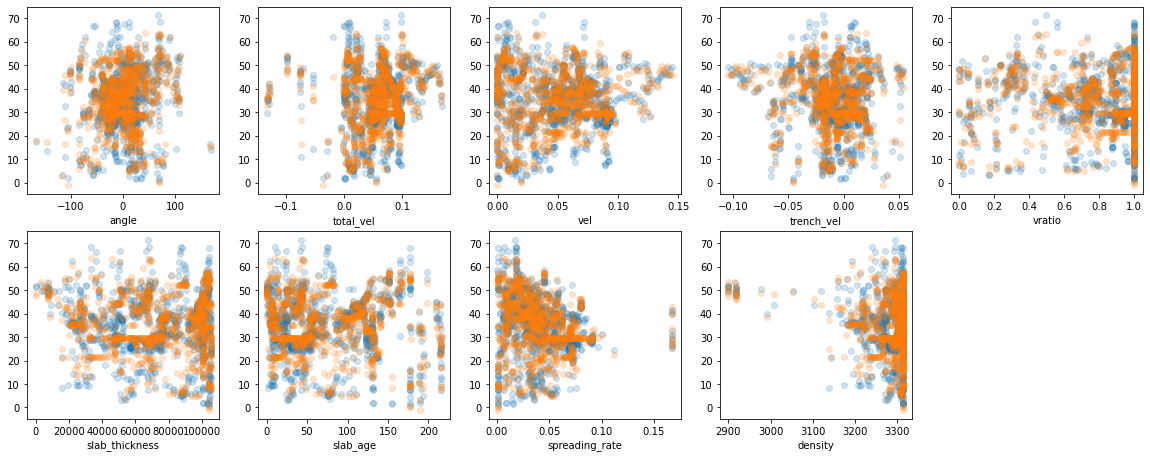

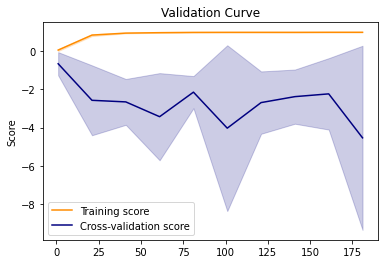

In [15]:
scaler = preprocessing.StandardScaler()
scaler.fit(df_X_train)
X_train = scaler.transform(df_X_train)

# I had to increase the maximum number of iterations
mlp = MLPRegressor(hidden_layer_sizes=(25,), solver='lbfgs', activation='tanh', max_iter=3000, tol=0.05)
mlp.fit(X_train, df_y_train.values)

print("R2 value = {:.2f}".format(mlp.score(X_train, df_y_train.values)))

scores = cross_val_score(mlp, X_train, y_train, cv=10)
print("MSE = {:.2e} +/- {:.2e}".format(-scores.mean(), scores.std()))

y_predict = mlp.predict(X_train)

fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    ax.scatter(df_X_train[variable_name], df_y_train, alpha=0.2)
    ax.scatter(df_X_train[variable_name], y_predict, alpha=0.2)
    
    
param_range = np.arange(1,200,20)

train_scores, test_scores = validation_curve(MLPRegressor(solver='lbfgs',activation='tanh',max_iter=3000,tol=0.05),
                                             X_train, y_train, 
                                             param_name="hidden_layer_sizes",
                                             param_range=param_range, 
                                             cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


fig = plt.figure()
ax = fig.add_subplot(111, title='Validation Curve', ylabel='Score')
ax.plot(param_range, train_scores_mean, label='Training score', color='darkorange')
ax.fill_between(param_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                alpha=0.2, color='darkorange')
ax.plot(param_range, test_scores_mean, label='Cross-validation score', color='navy')
ax.fill_between(param_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                alpha=0.2, color='navy')
ax.legend()

## Quantify relationships

Iteratively perturb a single parameter and fix the others

In [16]:
percentile_range = np.arange(1,100,1)
percentile_labels = ['{:.0f}%'.format(p) for p in percentile_range]

df_X_template = pd.DataFrame(index=percentile_labels, columns=variable_names)
for p, plabel in zip(percentile_range, percentile_labels):
    df_X_template.loc[plabel] = np.percentile(df_X_train, p, axis=0)

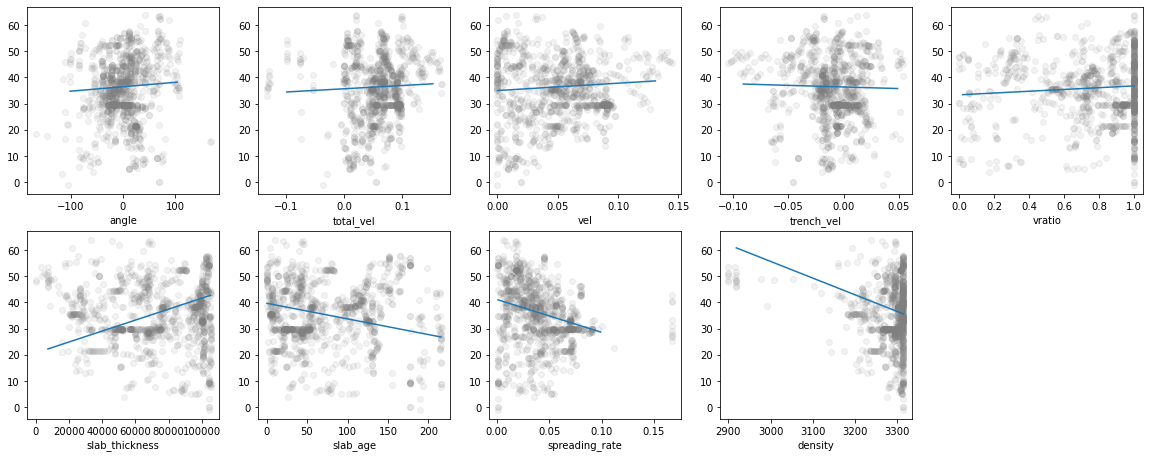

In [17]:
fig = plt.figure(figsize=(20,20))

gs = GridSpec(5,5)

for i, variable_name in enumerate(variable_names):
    ax = fig.add_subplot(gs[i], xlabel=variable_name)
    
    # create a matrix of median values
    df_X_new = df_X_template.copy()
    for index in df_X_new.index:
        df_X_new.loc[index] = df_X_template.loc['50%']
    
    # perturb variable
    df_X_new[variable_name] = df_X_template[variable_name]
    
    X_new = scaler.transform(df_X_new)
    
    # predict the slab dip using chosen regression
    y_new = regr.predict(X_new)
    
    ax.scatter(df_X_train[variable_name], y_predict, c='0.5', alpha=0.1)
    ax.plot(df_X_new[variable_name], y_new)

## Plot parameter relationships

It is helpful to delineate individual subduction zones from the entire cloud of points. We use the segment IDs of each point to plot the median and standard deviation for subduction zone segments.

In [18]:
from scipy.optimize import curve_fit

def linear_func(x, m, c=0):
    return m*x + c

# df = pd.read_csv("data/subduction_data.csv", index_col=0)
df_trench = pd.read_csv("data/trench_locations.csv")

In [41]:
def plot_segments(segment_IDs, var1, var2):
    
    v1, label1 = tuple(var1)
    v2, label2 = tuple(var2)
    
    fig = plt.figure(figsize=(8.5,4))
    
    ax1 = fig.add_subplot(121, xlabel=label1, ylabel=label2)
    sc1 = ax1.scatter(v1, v2, alpha=0.2, c='k')
    
    ax2 = fig.add_subplot(122, xlabel=label1, ylabel=label2)
    
    unique_segment_IDs, ncounts = np.unique(segment_IDs, return_counts=True)
    unique_segment_IDs = unique_segment_IDs[ncounts > 1]
    
    for index, segID in enumerate(unique_segment_IDs):
        mask_segment = segment_IDs == segID

        ax2.errorbar(np.nanmedian(v1[mask_segment]), np.nanmedian(v2[mask_segment]),
                     xerr=np.nanstd(v1[mask_segment]), yerr=np.nanstd(v2[mask_segment]),
                     fmt='o', capsize=3)
        
#     return fig

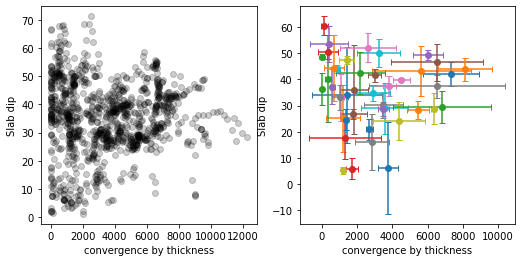

In [42]:
plot_segments(df['segment_ID'],
             (df['slab_thickness']*df['vel'], 'convergence by thickness'),
             (df['slab_dip'], 'Slab dip'))

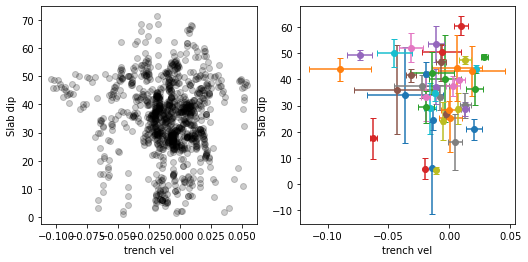

In [43]:
plot_segments(df['segment_ID'],
             (df['trench_vel'], 'trench vel'),
             (df['slab_dip'], 'Slab dip'))

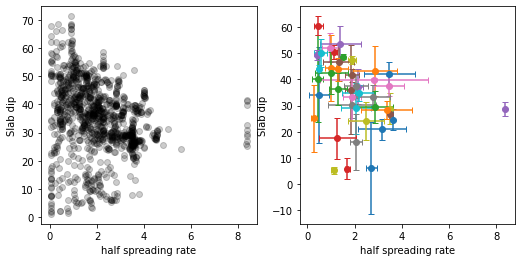

In [44]:
plot_segments(df['segment_ID'],
             (0.5*df['spreading_rate']*100, 'half spreading rate'),
             (df['slab_dip'], 'Slab dip'))

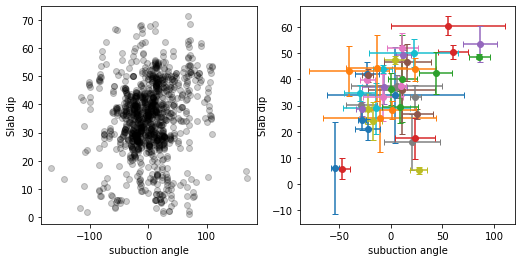

In [45]:
plot_segments(df['segment_ID'],
             (df['angle'], 'subuction angle'),
             (df['slab_dip'], 'Slab dip'))

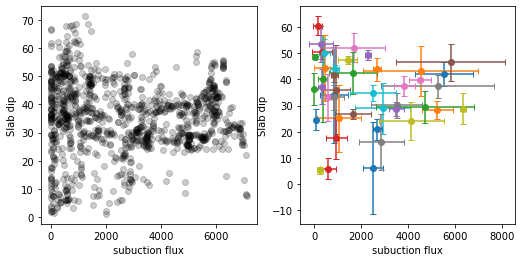

In [46]:
vratio = (df['vel'] + df['trench_vel'])/(df['vel'] + 1e-22)
vratio[df['slab_vel_abs'] < 0] *= -1
vratio = np.clip(vratio, 0, 1)



plot_segments(df['segment_ID'],
             ((df['vel']*vratio)*df['slab_thickness'], 'subuction flux'),
             (df['slab_dip'], 'Slab dip'))

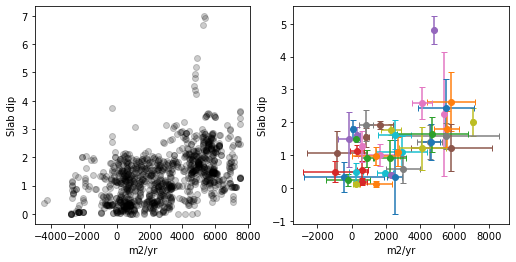

In [47]:
plot_segments(df['segment_ID'],
             ((df['slab_thickness']*(df['vel']+df['trench_vel'])), 'm2/yr'),
             (df['slab_dip']*df['spreading_rate'], 'Slab dip'))

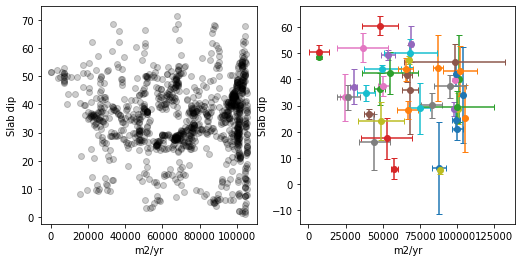

In [48]:
plot_segments(df['segment_ID'],
             ((df['slab_thickness']), 'm2/yr'),
             (df['slab_dip'], 'Slab dip'))

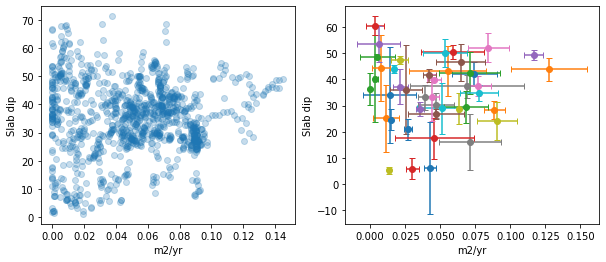

In [36]:
plot_segments(df['segment_ID'],
             ((df['vel']), 'm2/yr'),
             (df['slab_dip'], 'Slab dip'))

Associate segment IDs with trenches

In [89]:
trench_ID = np.zeros(df_trench.shape[0], dtype=int)

for row in range(df_trench.shape[0]):
    # find nearest trench segment using haversine distance
    dist = gplately.tools.haversine_distance(df['lon'], df_trench['Lon'][row], df['lat'], df_trench['Lat'][row])
    idx = dist.argmin()

    seg_ID = df['segment_ID'].iloc[idx]
    
    trench_ID[row] = seg_ID
    
df_trench = df_trench.assign(trench_ID=trench_ID)

In [99]:
df_trench

,Lon,Lat,Abbreviation,Name,Region,Type,trench_ID
0,-170,-15,Ton,Tonga,Oceania,Ocean - Ocean,21
1,-174,-35,Ker,Kermadec,Oceania,Ocean - Ocean,8
2,170,-16,NH,New Hebrides,Oceania,Ocean - Ocean,37
3,160,-9,Sol,Solomon,Oceania,Ocean - Continent,38
4,138,-1,PNG,Papua New Guinea,SE Asia,Ocean - Continent,39
5,112,-14,Java,Java,SE Asia,Ocean - Continent,31
6,85,-4,Sum,Sumatra,SE Asia,Ocean - Continent,9
7,59,30,Mak,Makran,SE Asia,Continent - Continent,36
8,30,30,Hel,Hellenic,Europe,Ocean - Continent,3
9,18,34,Cal,Calabria,Europe,Ocean - Continent,3


In [341]:
trench_ignore = []

def plot_segments(segment_IDs, var1, var2):
    
    v1, label1 = tuple(var1)
    v2, label2 = tuple(var2)
    
    fig = plt.figure(figsize=(8.5,4))
    
    ax1 = fig.add_subplot(121, xlabel=label1, ylabel=label2)
    hst = ax1.hist2d(v1, v2, bins=10, cmap='Greys')
    
    fig.colorbar(hst[3], ax=ax1, orientation='horizontal')
    
#     sc1 = ax1.scatter(v1, v2, alpha=0.2, c='k')
    
    ax2 = fig.add_subplot(122, xlabel=label1, ylabel=label2)
    
    unique_segment_IDs, ncounts = np.unique(segment_IDs, return_counts=True)
    unique_segment_IDs = unique_segment_IDs[ncounts > 1].tolist()
    
    for name in trench_ignore:
        # find segment ID
        segID = int(df_trench['trench_ID'][df_trench['Abbreviation'] == name])
        if segID in unique_segment_IDs:
            unique_segment_IDs.remove(segID)
    
    v1_median = np.zeros(len(unique_segment_IDs))
    v2_median = np.zeros(len(unique_segment_IDs))
    weights   = np.zeros(len(unique_segment_IDs))
    
    for index, segID in enumerate(unique_segment_IDs):
        mask_segment = segment_IDs == segID

        ax2.errorbar(np.nanmedian(v1[mask_segment]), np.nanmedian(v2[mask_segment]),
                     xerr=np.nanstd(v1[mask_segment]), yerr=np.nanstd(v2[mask_segment]),
                     fmt='o', capsize=3)
        
#         if segID in df_trench['trench_ID']:
#         print(df_trench['Abbreviation'][df_trench['trench_ID'] == index])
#         if df_trench['Abbreviation'][df_trench['trench_ID'] == index].tolist():
#             ax2.text(np.nanmedian(v1[mask_segment]), np.nanmedian(v2[mask_segment]),
#                      df_trench['Abbreviation'][df_trench['trench_ID'] == index].tolist()[0])
    
        v1_median[index] = np.nanmedian(v1[mask_segment])
        v2_median[index] = np.nanmedian(v2[mask_segment])
        weights[index] = np.count_nonzero(mask_segment)
        
    popt, pcov = curve_fit(linear_func, v1_median, v2_median, sigma=weights)

    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    
    x_range  = np.linspace(xmin, xmax, 10)
    ax2.plot(x_range, linear_func(x_range, *popt), c='k')

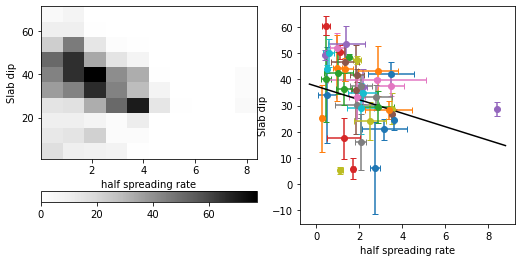

In [342]:
plot_segments(df['segment_ID'],
             (0.5*df['spreading_rate']*100, 'half spreading rate'),
             (df['slab_dip'], 'Slab dip'))

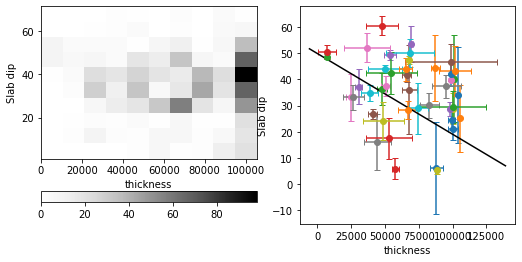

In [343]:
plot_segments(df['segment_ID'],
             (df['slab_thickness'], 'thickness'),
             (df['slab_dip'], 'Slab dip'))

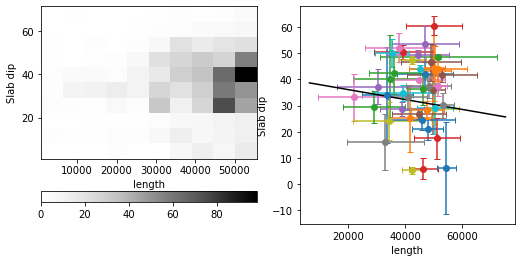

In [344]:
plot_segments(df['segment_ID'],
             (df['length'], 'length'),
             (df['slab_dip'], 'Slab dip'))

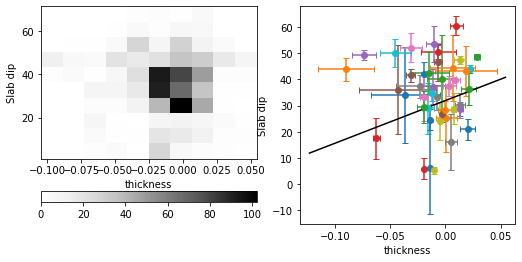

In [345]:
plot_segments(df['segment_ID'],
             (df['trench_vel'], 'thickness'),
             (df['slab_dip'], 'Slab dip'))

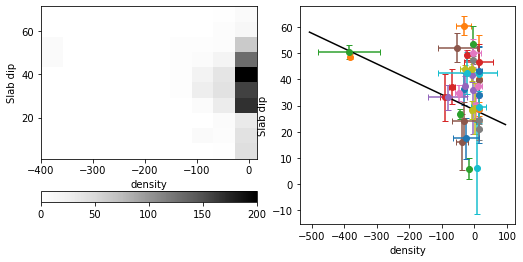

In [365]:
plot_segments(df['segment_ID'],
             ((df['relative_density']), 'density'),
             (df['slab_dip'], 'Slab dip'))

There is a good relationship between slab dip with slab flux and spreading rate. Let's plot these properly...

In [350]:
trench_ignore = ['LAT', 'Hel', 'Cal', 'Ryu', 'Ph']

def segmentise_variables(v1, v2):
    v1_median = []
    v2_median = []
    v1_std = []
    v2_std = []
    
    Tidx = []
    trench_lengths = []

    trench_segment_ID = np.unique(df['segment_ID'])
    
    for i, seg_ID in enumerate(trench_segment_ID):
        mask_segment = df['segment_ID'] == seg_ID
        mask_segment = np.logical_and(mask_segment, df['vel'] > 0.01)
        if mask_segment.any():
            if np.isfinite(np.nanmedian(v1[mask_segment])) \
            and np.mean(df['vel'][mask_segment]) > 0.01 \
            and df_trench['Abbreviation'] not in trench_ignore:
                v1_median.append( np.nanmean(v1[mask_segment]) )
                v2_median.append( np.nanmean(v2[mask_segment]) )
                v1_std.append( np.nanstd(v1[mask_segment]) )
                v2_std.append( np.nanstd(v2[mask_segment]) )
                trench_lengths.append(np.sum(df['length'][mask_segment]))
                Tidx.append(i)
            
    return np.array(v1_median), np.array(v2_median), np.array(v1_std), np.array(v2_std), np.array(trench_lengths), Tidx

def linear_func(x, a, b):
    return a*x + b

In [367]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

R = 0.20, P = 0.39, std = 94.66
R = 0.13, P = 0.59, std = 0.00
R = -0.22, P = 0.34, std = 108.22


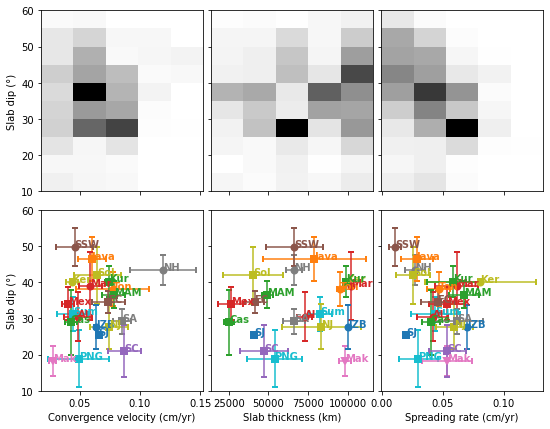

In [373]:
unique_segment_IDs = np.unique(df['segment_ID'])

trench_type_dict = {'Ocean - Ocean': 'o', 'Ocean - Continent': 's', 'Continent - Continent': 'v'}
trench_type_color= {'Ocean - Ocean': '#6A5ACD', 'Ocean - Continent': '#E9967A', 'Continent - Continent': '#2E8B57'}


gs = GridSpec(2,3, wspace=0.05, hspace=0.1)

fig = plt.figure(figsize=(9,7))

for r, (key, label) in enumerate(zip(['vel', 'slab_thickness', 'spreading_rate'],
                                ['Convergence velocity (cm/yr)', 'Slab thickness (km)', 'Spreading rate (cm/yr)'])):
    
    ax1 = fig.add_subplot(gs[0,r], )
    ax2 = fig.add_subplot(gs[1,r], xlabel=label)

    
    v1 = df[key]
    v2 = df['slab_dip']
    
    v1_median = np.zeros(df_trench.shape[0])
    v2_median = np.zeros(df_trench.shape[0])
    v1_std    = np.zeros(df_trench.shape[0])
    v2_std    = np.zeros(df_trench.shape[0])
    trench_lengths = np.zeros(df_trench.shape[0])
    
    for i in range(df_trench.shape[0]):

        # find nearest trench segment using haversine distance
        dist = gplately.tools.haversine_distance(df['lon'], df_trench['Lon'][i], df['lat'], df_trench['Lat'][i])
        idx = dist.argmin()
        
        seg_ID = df['segment_ID'].iloc[idx]
        mask_segment = df['segment_ID'] == seg_ID
        mask_segment = np.logical_and(mask_segment, df['vel'] > 0.01)
        
        if mask_segment.any() and df_trench['Abbreviation'][i] not in trench_ignore:
        
            v1_median[i] = np.nanmean(v1[mask_segment])
            v2_median[i] = np.nanmean(v2[mask_segment])
            v1_std[i] = np.nanstd(v1[mask_segment])
            v2_std[i] = np.nanstd(v2[mask_segment])
            trench_lengths[i] = np.sum(df['length'][mask_segment])


            ax2.errorbar(v1_median[i], v2_median[i], xerr=v1_std[i], yerr=v2_std[i],
                         marker=trench_type_dict[df_trench['Type'][i]],
                         #markersize='{:f}'.format(trench_lengths[i]*5e-6 + 5),
                         #markeredgecolor=trench_type_color[df_trench['Type'][i]],
                         markeredgewidth=2,
                         #ecolor=trench_type_color[df_trench['Type'][i]],
                         capsize=3, color='C{}'.format(seg_ID))

            ax2.text(v1_median[i], v2_median[i], df_trench['Abbreviation'][i],
                     color='C{}'.format(seg_ID), fontweight='bold')
            
        else:
            v1_median[i] = np.nan

    #     ax.errorbar(np.nanmedian(v1[mask_segment]), np.nanmedian(v2[mask_segment]),
    #                 xerr=np.nanstd(v1[mask_segment]), yerr=np.nanstd(v2[mask_segment]),
    #                 fmt='o', capsize=3)

    # linear regression
    mask_real = np.logical_and(np.isfinite(v1_median), np.isfinite(v2_median))
    
    popt, pcov = curve_fit(linear_func, 
                           v1_median[mask_real],
                           v2_median[mask_real],
                           sigma=1.0/trench_lengths[mask_real],
                           )
    
    residuals = v2_median[mask_real] - linear_func(v1_median[mask_real], *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((v2_median[mask_real] - np.mean(v2_median[mask_real]))**2)
    r_squared = 1.0 - (ss_res / ss_tot)

    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    ymin, ymax = 10, 60
    
    x_range  = np.linspace(xmin, xmax, 10)
#     print(r_squared)
    slope, intercept, r_value, p_value, std_err = linregress(v1_median[mask_real], v2_median[mask_real])
    print("R = {:.2f}, P = {:.2f}, std = {:.2f}".format(r_value, p_value, std_err))
#     ax2.plot(x_range, linear_func(x_range, *popt), 'k')
    # ax2.text(0.6,0.9, "$R^2$ = {:.2f}".format(r_squared), transform=ax2.transAxes)
    
    
    hst = ax1.hist2d(v1, v2, bins=(5, 10), cmap='Greys',
                     range=((xmin,xmax),(ymin,ymax)))

    
    ax1.set_xlim(xmin, xmax)
    ax2.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)
    ax2.set_ylim(ymin, ymax)
    ax1.set_xticklabels([])
#     ax1.set_title(label)
    if r > 0:
        ax2.set_yticklabels([])
        ax1.set_yticklabels([])
    else:
        ax1.set_ylabel('Slab dip (°)')
        ax2.set_ylabel('Slab dip (°)')

fig.savefig("slab_dip_parameter_correlations.pdf", dpi=300, bbox_inches='tight')

## Save summary statistics for each subduction zone

Save to a csv file

In [25]:
unique_segment_IDs = np.unique(df['segment_ID'])

empty_data = np.zeros((len(unique_segment_IDs), len(df.columns)))

# initialise empty data frames
df_segments = pd.DataFrame(data=empty_data, columns=df.columns)
df_segments_std = pd.DataFrame(data=empty_data.copy(), columns=df.columns)

length_ratio = np.zeros(len(unique_segment_IDs))

for i, seg_ID in enumerate(unique_segment_IDs):
    mask_segment = df['segment_ID'] == seg_ID
    
    for column in df:
        # take the median
        df_segments[column][i] = np.nanmedian(df[column][mask_segment])
        df_segments_std[column][i] = np.nanstd(df[column][mask_segment])
        
    # some variables require summing
    df_segments['length'][i] = np.nansum(df['length'][mask_segment])
    
    xs, ys, zs = gplately.tools.lonlat2xyz(df['lon'], df['lat'])
    xyz = np.c_[xs,ys,zs]
    
    # distance as the bird flies from start to end of trench
    dist_bird = np.linalg.norm(xyz[-1] - xyz[0])
    
    # divide this by the total length
    length_ratio[i] = dist_bird/df_segments['length'][i]

In [26]:
df_segments.to_csv('data/subduction_segments_data.csv')
df_segments_std.to_csv('data/subduction_segments_data_std.csv')